# Figure 5

This notebook produces Figure 5 and other auxiliary figures.

## Get data

We get the Data from Felikson et al. (2021) and ITS_LIVE (Gardner et al., 2018; Gardner et al., 2019) again. See `Fig3-4.ipynb` for more details.

In [1]:
%%bash

if [ ! -d ../data/Felikson2021/ ]; then
    wget https://zenodo.org/record/4284759/files/netcdfs.zip -P ../data/Felikson2021/ --no-verbose
    unzip ../data/Felikson2021/netcdfs.zip -d ../data/Felikson2021/
    rm -rf ../data/Felikson2021/netcdfs.zip
fi

In [2]:
%%bash

if [ ! -f ../data/GRE_G0240_1998_v.tif ]; then
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_1998_v.tif -P ../data/ --no-verbose
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/GRE_G0240_diff-2018-1998_v.tif -P ../data/ --no-verbose
fi

To save some processing time, we can get the `mega_results_Greenland.h5` file containing the results. See Analysis Section for more information.

In [3]:
%%bash

if [ ! -f ../data/results/mega_results_Greenland.h5 ]; then
    wget https://github.com/whyjz/pejzero/releases/download/v0.1/mega_results_Greenland.h5 -P ../data/results/ --no-verbose
fi

## Analysis

In [4]:
import pejzero
import rasterio
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import pandas as pd

We select and process 104 glaciers with valid key parameters at 3 km from the terminus. Also, we stick to the same ITS_LIVE rasters we use for Figure 3.

In [5]:
netcdf_dir = '../data/Felikson2021'
glacier_labels = ['0001', '0003', '0004', '0005', '0007', '0009', '0010', '0014', '0015', '0016', 
                  '0019', '0020', '0021', '0022', '0024', '0025', '0027', '0029', '0035', '0036',
                  '0037', '0039', '0043', '0046', '0047', '0048', '0049', '0050', '0052', '0054', 
                  '0058', '0059', '0085', '0099', '0103', '0105', '0106', '0111', '0113', '0114',
                  '0115', '0116', '0124', '0129', '0135', '0152', '0167', '0168', '0174', '0177',
                  '0181', '0183', '0207', '0208', '0212', '0213', '0217', '0245', '0252', '0276',
                  '0277', 'a006', 'a011', 'a030', 'a031', 'a033', 'a034', 'a045', 'a061', 'a112', 
                  'a132', 'a147', 'a148', 'a173', 'a184', 'a199', 'a251', 'a260', 'b006', 'b011',
                  'b030', 'b031', 'b033', 'b034', 'b045', 'b061', 'b132', 'b147', 'b148', 'b173',
                  'b184', 'b199', 'b216', 'b251', 'c031', 'c033', 'c034', 'c061', 'c173', 'c184', 
                  'c216', 'd173', 'd184', 'd216']

glaciers = [netcdf_dir + '/glacier' + i + '.nc' for i in glacier_labels]
print('glaciers total: {}'.format(len(glaciers)))

glaciers total: 104


Besides the ITS_LIVE speed files, here we include the Greenland glacier retreat data to prepare the data table for **Figure 6**. The original glacier retreat data are available at https://doi.org/10.7280/D1667W as the form of terminal position time series. We manually measure the retreat for all 104 glacier outlets and save the results as `GrIS_ice-retreat.csv`, see Section 3.1 for more details. 

Reference: Wood, M., Rignot, E., Fenty, I., An, L., Bjørk, A., van denBroeke, M., Cai, C., Kane, E., Menemenlis, D., Millan, R., Morlighem, M., Mouginot, J., Noël, B., Scheuchl, B., Velicogna, I., Willis, J. K., &Zhang, H. (2021). Ocean forcing drives glacier retreat in Greenland. Science Advances, 7(1), 1–11. https://doi.org/10.1126/sciadv.aba7282

In [6]:
speed_file = '../data/GRE_G0240_1998_v.tif'
vdiff_file = '../data/GRE_G0240_diff-2018-1998_v.tif'
retreat_file = '../data/GrIS_ice-retreat.csv'

Process all the selected flowlines and save the results as `mega_results_Greenland.h5`. We have commented out the cell below because it takes some time to run. We have uploaded the results on Zenodo to read the results directly. If you wish to repeat/verify the $P_e$-$J_0$ calculation, you can uncomment the cell below and regenerate the `mega_results_Greenland.h5 file`.

In [7]:
# mega_results = {}

# with rasterio.open(speed_file) as speed_data, rasterio.open(vdiff_file) as vdiff_data:
#     for glacier_file in glaciers:
#         ds = Dataset(glacier_file, 'r')
#         flowline_groups, _ = pejzero.get_flowline_groups(ds)
#         primary_flowlines = [i for i in flowline_groups if 'iter' not in i.path]

#         results = {}

#         for flowline_group in primary_flowlines:

#             data_group = pejzero.cal_pej0_for_each_flowline(flowline_group, speed_data, vdiff_data)

#             if data_group is not None:
#                 results[flowline_group.name] = data_group

#         results['avg'] = pejzero.cal_avg_for_each_basin(results)
#         mega_results[Path(glacier_file).stem[-4:]] = results

# pejzero.save_pej0_results(mega_results, "../data/results/mega_results_Greenland.h5")

Now we read the data from the HDF5 file. If you rerun the cell above and already get the `mega_results` variable, then you can safely comment this cell out.

In [8]:
mega_results = pejzero.load_pej0_results("../data/results/mega_results_Greenland.h5")

We extract 4 features for each average flowline, convert them to a Pandas dataframe, and save them into a CSV file for **Figure 6**:

1. $P_e/\ell$ at 3 km (the closest $P_e/\ell$ reading to the terminus)
2. $J_0$ at 3 km (the closest $J_0$ reading to the terminus)
3. Speed change (as *both* absolute difference and percentage difference, so it takes two columns)
4. Terminus advance (i.e. retreat would be a negative value)

We have commented out this cell out because `pej0_GrIS_classification.csv` is provided along with the workflows. That said, you can always uncomment the cell below and regenerate it.

In [9]:
# retreat = pd.read_csv(retreat_file)

# to_df = []

# for key in mega_results:
#     u1998 = next(x for x in mega_results[key]['avg']['u'] if not np.isnan(x))
#     udiff = next(x for x in mega_results[key]['avg']['udiff_sm'] if not np.isnan(x))
#     front_pos = retreat.loc[retreat['ID'] == key]['advance (km)']
#     to_df.append([next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)), 
#                   next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)), 
#                   udiff,
#                   100 * udiff / u1998,
#                   float(front_pos)])
    
# df = pd.DataFrame(to_df, columns=[r'$\frac{P_e}{\ell}$ (m$^{-1}$)', r'$J_0$ (m yr$^{-1}$)', 'Speed diff (m yr$^{-1}$)', 'Speed diff (%)', 'Advance (km)'])
# df.to_csv('../data/results/pej0_GrIS_classification.csv', index=False)

## Visualization

Firstly we design a color map based on the 1998-2018 speed change. This color map uses 8 nodes that stretch from -500 m/yr to 3500/yr.

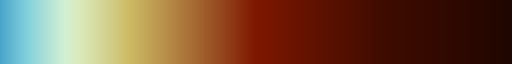

In [10]:
# Version 2 (revised submission, based on the roma colormap https://github.com/GenericMappingTools/gmt/blob/master/share/cpt/roma.cpt)
colors = np.array([[56,156,198,230],
                   [100,198,213,210],
                   [192,234,195,180],
                   [207,229,168,190],
                   [200,180,85,230],
                   [126,23,0,255],
                   [63,12,0,255],
                   [32,6,0,255]])
colors = colors / 255
nodes = (np.array([-500, -300, 0, 100, 500, 1500, 2500, 3500]) + 500) / 4000
mycmap = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))
mycmap

We can make **Figure 5** by color coding each average glacier flowline using `mycmap` in the profile and the $J_0$ versus $P_0/\ell$ plots. 

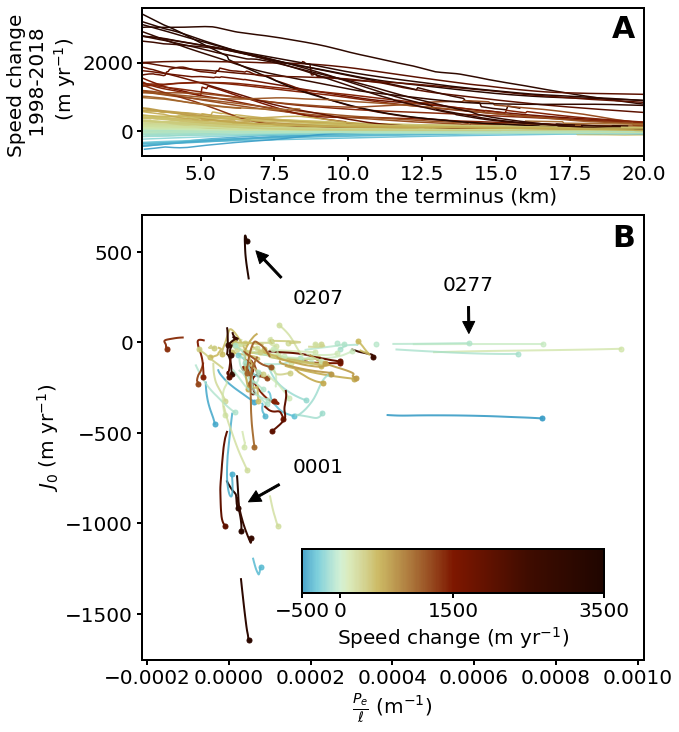

In [11]:
matplotlib.rc('font', size=20)
matplotlib.rc('axes', linewidth=2)

fig, ax4 = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(9, 12))

# ==== plot data and annotations
for key in mega_results:
    z_max = np.nanmax(mega_results[key]['avg']['udiff_sm'])
    z_min = np.nanmin(mega_results[key]['avg']['udiff_sm'])
    z_value = z_max if abs(z_max) > abs(z_min) else z_min
    z_value_scaled = (z_value + 500) / 4000
    rgba = mycmap(z_value_scaled)
    ax4[0].plot(mega_results[key]['avg']['d'], mega_results[key]['avg']['udiff_sm'], color=rgba)
    ax4[1].plot(mega_results[key]['avg']['pe_ignore_dslope'][:100], mega_results[key]['avg']['j0_ignore_dslope'][:100], color=rgba, linewidth=2)
    pinhead_cor = (next(x for x in mega_results[key]['avg']['pe_ignore_dslope'] if not np.isnan(x)),
                   next(x for x in mega_results[key]['avg']['j0_ignore_dslope'] if not np.isnan(x)))
    ax4[1].plot(pinhead_cor[0], pinhead_cor[1], '.', color=rgba, markersize=10)
    annot_arrowprops = {'facecolor': 'black', 'shrink': 0.2, 'width': 2}
    if key == '0001':
        ax4[1].annotate('0001', xy=pinhead_cor, xytext=(0.3, 0.42), textcoords='axes fraction', arrowprops=annot_arrowprops)
    elif key == '0207':
        ax4[1].annotate('0207', xy=pinhead_cor, xytext=(0.3, 0.8), textcoords='axes fraction', arrowprops=annot_arrowprops)
    elif key == '0277':
        ax4[1].annotate('0277', xy=pinhead_cor, xytext=(0.6, 0.83), textcoords='axes fraction', arrowprops=annot_arrowprops)

# ==== Add supplemental text and labels
letter_specs = {'fontsize': 30, 'fontweight': 'bold', 'va': 'top', 'ha': 'center'}
ax4[0].set_xlim([3, 20])
ax4[0].set_xlabel('Distance from the terminus (km)')
label_top = ax4[0].set_ylabel('Speed change \n 1998-2018 \n (m yr$^{-1}$)')
ax4[0].text(0.96, 0.95, 'A', transform=ax4[0].transAxes, **letter_specs)
ax4[0].tick_params(width=2, length=5)
ax4[1].set_xlabel(r'$\frac{P_e}{\ell}$ (m$^{-1}$)')
ax4[1].set_ylabel(r'$J_0$ (m yr$^{-1}$)')
ax4[1].text(0.96, 0.98, 'B', transform=ax4[1].transAxes, **letter_specs)
ax4[1].tick_params(width=2, length=5)

# ==== Place a color bar 
cbaxes = ax4[1].inset_axes([0.32, 0.15, 0.6, 0.1])
norm = matplotlib.colors.Normalize(vmin=-500, vmax=3500)
bounds = [-500, 0, 1500, 3500]
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=mycmap),
             cax=cbaxes, orientation='horizontal', label='Speed change (m yr$^{-1}$)', ticks=bounds)
cbaxes.tick_params(width=2, length=5)
    
fig.savefig('../data/results/Fig5.pdf', bbox_extra_artists=(label_top,), bbox_inches='tight')

## Exploring the results

These extra cells provide a general overview of the data structure of `mega_results.h5`. It is a three-layered dictionary structure:

- The first layer is indexed by the glacier ID (see the cell below).
- The second layer contains results for each flowline and for the average values.
- The third layer contains all variables along the flowline distance. All variables are smoothed using the Savitzky-Golay filter (see Section 3.1) unless otherwise noted. 

The second and third layers are identical to the nested structure of the `results` variable in `Fig3-4.ipynb`.

In [12]:
for key in mega_results['a034']:    # This is Alison glacier (see Figure 1). You can replace the ID with any one we select in the beginning of this notebook.
    print(key)

avg
flowline03
flowline04
flowline05
flowline06
flowline07
flowline08


In [13]:
mega_results['a034']['avg']    # Average of Alison's 6 primary flowlines

{'b': array([      nan,       nan,       nan, ..., 602.95337, 603.01636,
        603.074  ], dtype=float32),
 'd': array([0.0000e+00, 5.0000e-02, 1.0000e-01, ..., 1.3410e+02, 1.3415e+02,
        1.3420e+02], dtype=float32),
 'j0': array([        nan,         nan,         nan, ..., 14.26131558,
        14.80505341, 15.32604264]),
 'j0_ignore_dslope': array([        nan,         nan,         nan, ..., -4.34209113,
        -4.40261348, -4.46299192]),
 'pe': array([           nan,            nan,            nan, ...,
        5.77694301e-05, 5.83274997e-05, 5.88461048e-05]),
 'pe_ignore_dslope': array([           nan,            nan,            nan, ...,
        2.91079403e-05, 2.86310854e-05, 2.81535963e-05]),
 's': array([      nan,       nan,       nan, ..., 2096.6362, 2097.0464,
        2097.4556], dtype=float32),
 'term1': array([          nan,           nan,           nan, ..., 6.9380649e-06,
        6.9413554e-06, 6.9449325e-06], dtype=float32),
 'term2': array([           nan,      